# Analysis of Sensor Data from Vivalink Wearable Device

## Imports

In [355]:
# Data packages
import numpy as np
import pandas as pd
import json

# Visualisation packages
from matplotlib import pyplot as plt

# Scientific packages
import scipy.signal as sig
import peakutils
import math

# Other
import re
from typing import List

## Load Data

The sensor data is in a .log file arranged in a key, value format. The key is the retrieval timestamp and all our required data is stored in the value. We will need to parse this for each line in the .log file and store the parsed data in a pandas dataframe for easier analysis and visualisation.

In [356]:
with open('ecg.log', 'r') as file:
    log_data = file.readlines()

In [357]:
def parse_log_data(log_data: List[str], split_pattern: str = '') -> pd.DataFrame:
    """Parse values from log file of key, value format and convert to pandas dataframe."""
    
    parsed_data = [json.loads(re.split(split_pattern, line)[-1].strip('\n')) for line in log_data]
    
    data_dict = {}

    for data in parsed_data:
        for key, value in data.items():
            if key not in data_dict:
                data_dict[key] = [value]
            else:
                data_dict[key].append(value)

    return pd.DataFrame(data_dict)

In [358]:
df = parse_log_data(log_data, split_pattern='\s\d{2}\:\d{2}\:\d{2}\.\d{3}\:') # This regex pattern allows us to split each line after the timestamp, isolating the data we need.

We can now have a quick look at how the data is organised and which features it contains.

In [359]:
df.head(2)

,accActivity,deviceId,receiveTime,temperature,accAccuracy,sf,deviceName,posture,dataMode,rr,...,deviceSN,leadOn,rri,ecg,recordTime,flash,activityScore,accFrequency,hr,modeType
0,0,F0:A8:F1:BC:D8:F6,1678174379439,33.00,2048,128,ECGRec_202309/C881512,3,fullDual,16,...,202309/C881512,1,"[1101, 0, 0, 0, 0]","[149, 172, 196, 225, 254, 278, 304, 325, 333, ...",1678174367734,1,0,5,55,mode4
1,0,F0:A8:F1:BC:D8:F6,1678174379439,33.00,2048,128,ECGRec_202309/C881512,3,fullDual,16,...,202309/C881512,1,"[1101, 0, 0, 0, 0]","[21, 30, 37, 37, 46, 51, 62, 71, 78, 88, 99, 1...",1678174368734,1,0,5,55,mode4


In [360]:
df.columns

Index(['accActivity', 'deviceId', 'receiveTime', 'temperature', 'accAccuracy',
       'sf', 'deviceName', 'posture', 'dataMode', 'rr', 'activity', 'rwl',
       'magnification', 'accStepOffset', 'avRR', 'rmssd', 'accStepTotal',
       'battery', 'acc', 'effective', 'deviceSN', 'leadOn', 'rri', 'ecg',
       'recordTime', 'flash', 'activityScore', 'accFrequency', 'hr',
       'modeType'],
      dtype='object')

For the purposes of this analysis we will just examine the ecg data and the acceleration data.

## ECG

For the ECG data we will look at a 20 second window, analyse how a filter could potentially be used to remove noise, and apply a smoothing function to aid in identifying the R peaks. This will allow us to calculate the RRI and, from that, the heart rate.

The RRI and heartrate are actually provided to us in the data but it will be an interesting exercise to calculate these manually.

In [361]:
ecg_sum = df.ecg.sum() # Concatenate the individual sample arrays of ecg data into a single continuous array

In [362]:
sample_frequency = 128 # How many samples per second, stated in log data
sample_seconds = 20 # Our desired time range

In [363]:
ecg_signal = ecg_sum[: sample_seconds * sample_frequency]

# Apply a butterworth filter to cut unfeasible ranges
lowpass = 100
highpass = 0.01
a, b = sig.butter(6, (highpass, lowpass), btype='bandpass', analog=True)
filtered_signal = sig.lfilter(b, a, ecg_signal)

# Use cubic spline coefficients for 1d array to smooth signal
smoothed_signal = sig.cspline1d(filtered_signal, lamb=500)

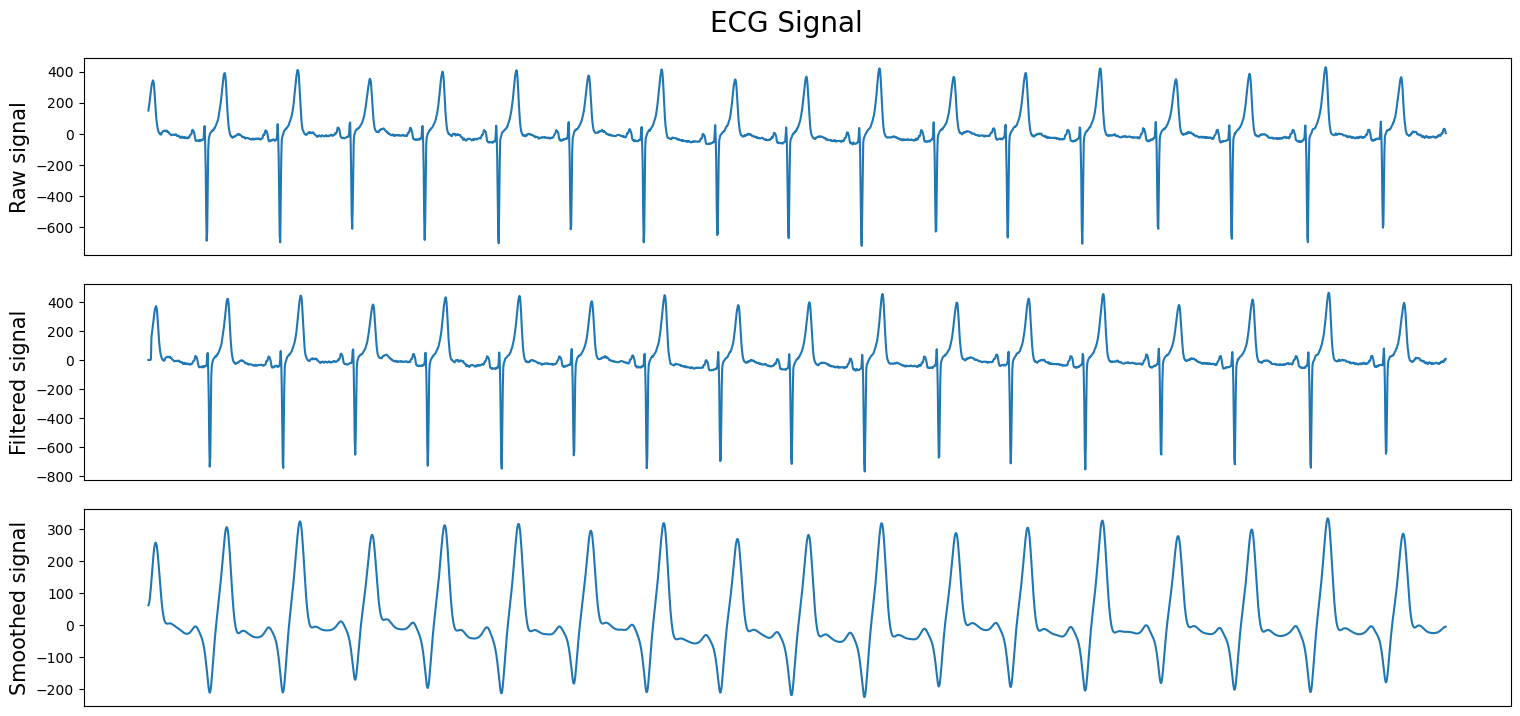

In [368]:
fig, ax = plt.subplots(3, 1, sharex=True)
fig.set_figheight(7.5)
fig.set_figwidth(15)

fig.suptitle("ECG Signal", fontsize = 20)
fig.tight_layout()

ax[0].plot(ecg_signal)
ax[0].set_ylabel('Raw signal', fontdict = {'size':15})
ax[1].plot(filtered_signal)
ax[1].set_ylabel('Filtered signal', fontdict = {'size':15})
ax[2].plot(smoothed_signal)
ax[2].set_ylabel('Smoothed signal', fontdict = {'size':15})

ax[0].set_xticklabels([])
ax[0].xaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[2].xaxis.set_ticks_position('none')

plt.show()

From the above visualisation we can see that not much noise was present in the raw signal. The smoothed signal however is noticably different and may be useful for accurately identifying all of the R peaks without accidentally picking up some false positives.

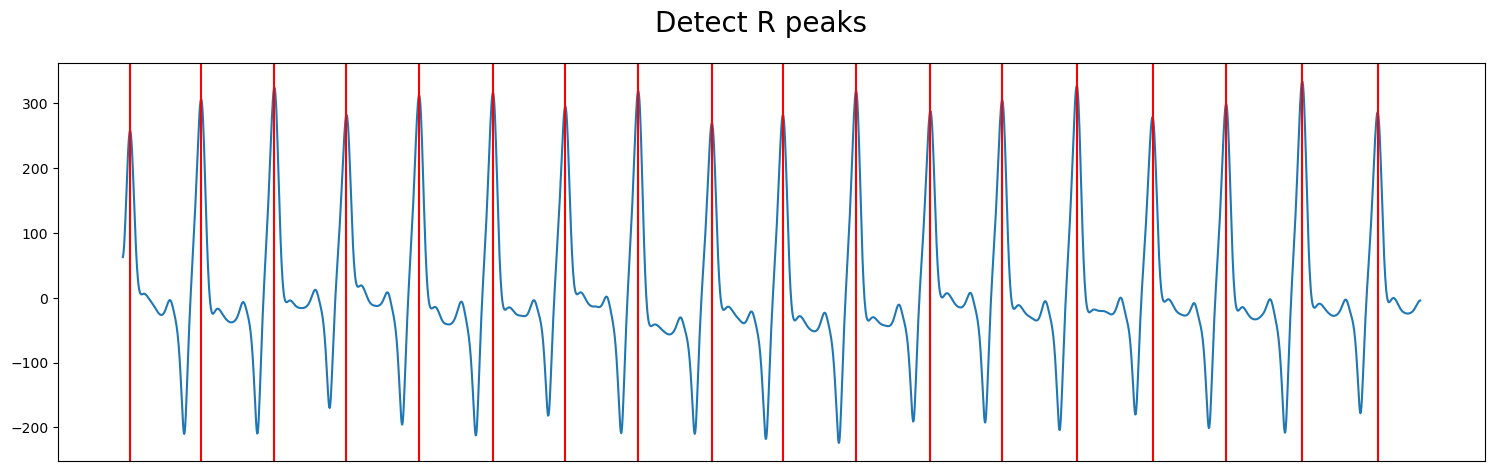

In [365]:
r_peaks = peakutils.indexes(smoothed_signal, thres=0.3, min_dist=100) # Python package for peak identification in signal data

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle("Detect R peaks", fontsize = 20)
fig.tight_layout()

ax.plot(smoothed_signal)

for peak in r_peaks: 
    ax.axvline(x=peak, color='r')

ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none')

We can see from the above visualisation that all of the R peaks have been accurately identified. We can now calculate the RRI using numpy and this can then be converted into the heartrate.

In [366]:
rr_intervals = np.diff(r_peaks) / sample_frequency
heart_rate = 60 / rr_intervals

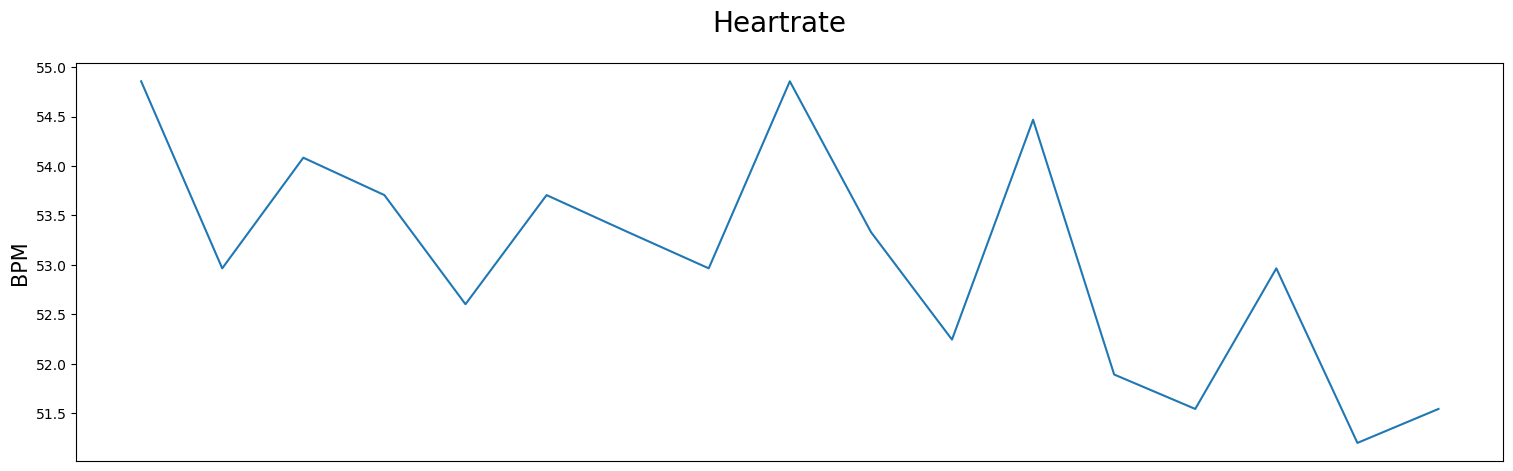

In [367]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

fig.suptitle("Heartrate", fontsize = 20)
fig.tight_layout()

ax.plot(heart_rate)
ax.set_ylabel('BPM', fontdict = {'size':15})

ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none')

plt.show()

# Acceleration

The acceleration data is stored in a multi-dimensional array to represent three different axes of movement - x, y and z. We will examine these values independently, before combining them into a single acceleration magnitude. We will then apply similar processing to that which we used for the ecg data to smooth the signal and identify the peaks. The count of these peaks should provide us with a step count of the user over the duration of the provided log data.

In [139]:
acc_sum = df.acc.sum() # Concatenate the individual multi-dimensional sample arrays of acceleration data into a single continuous multi-dimensional array

In [370]:
x_data = [acc[0] / 1000 for acc in acc_sum]
y_data = [acc[1] / 1000 for acc in acc_sum]
z_data = [acc[2] / 1000 for acc in acc_sum]

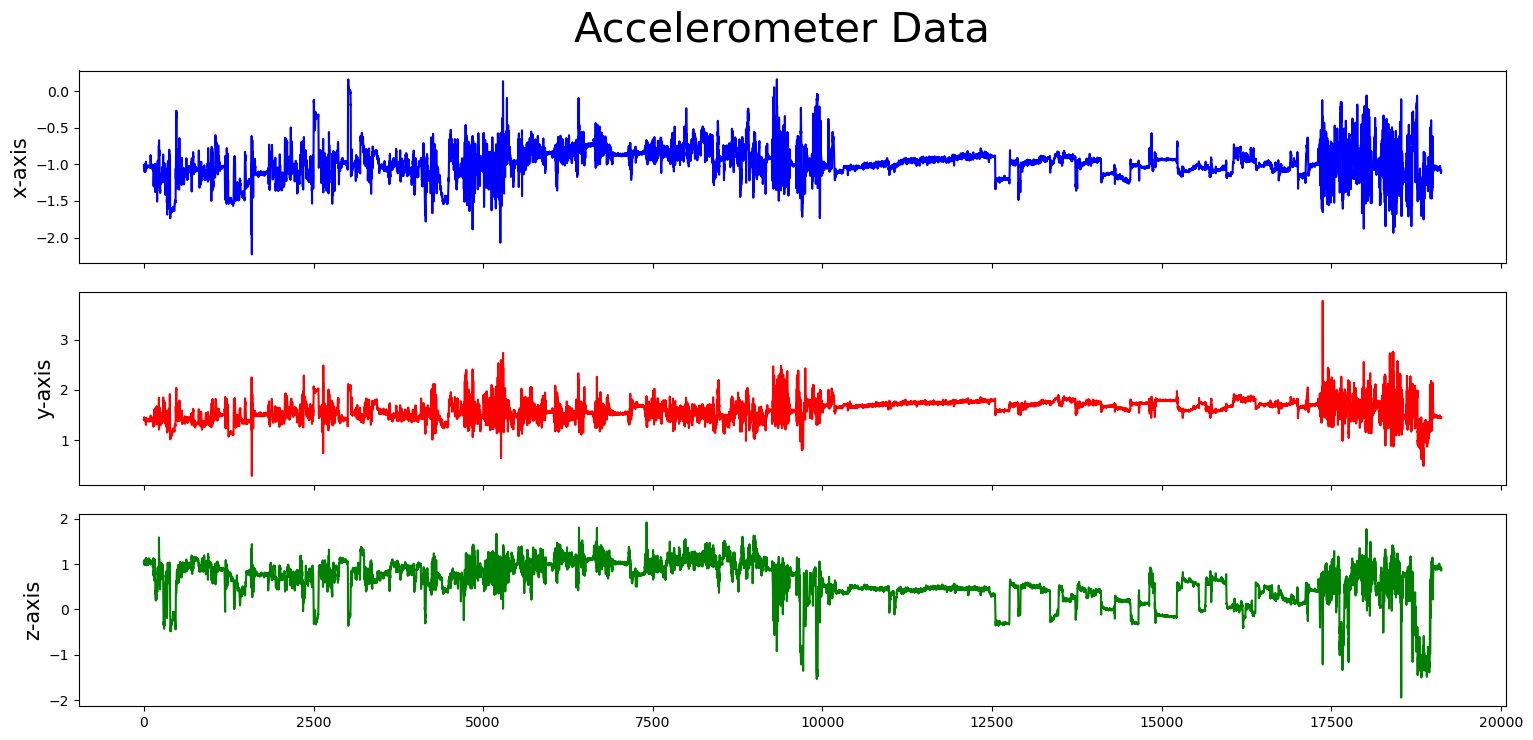

In [371]:
fig, ax = plt.subplots(3,1, sharex=True)
fig.set_figheight(7.5)
fig.set_figwidth(15)

fig.suptitle("Accelerometer Data", fontsize = 30)
fig.tight_layout()

ax[0].plot(x_data, 'b')
ax[0].set_ylabel('x-axis', fontdict = {'size':15})
                
ax[1].plot(y_data, 'r')
ax[1].set_ylabel('y-axis', fontdict = {'size':15})

ax[2].plot(z_data, 'g')
ax[2].set_ylabel('z-axis', fontdict = {'size':15})

plt.show()

We can now use the formula below to combine the three axis acceleration into a single acceleration magnitude.

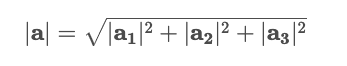

In [372]:
acc_mag = pd.Series(np.array(x_data)**2 + np.array(y_data)**2 + np.array(z_data)**2).apply(math.sqrt)

And apply our smoothing function.

In [380]:
smoothed_acc_mag = pd.Series(sig.cspline1d(acc_mag.values, lamb=1000))

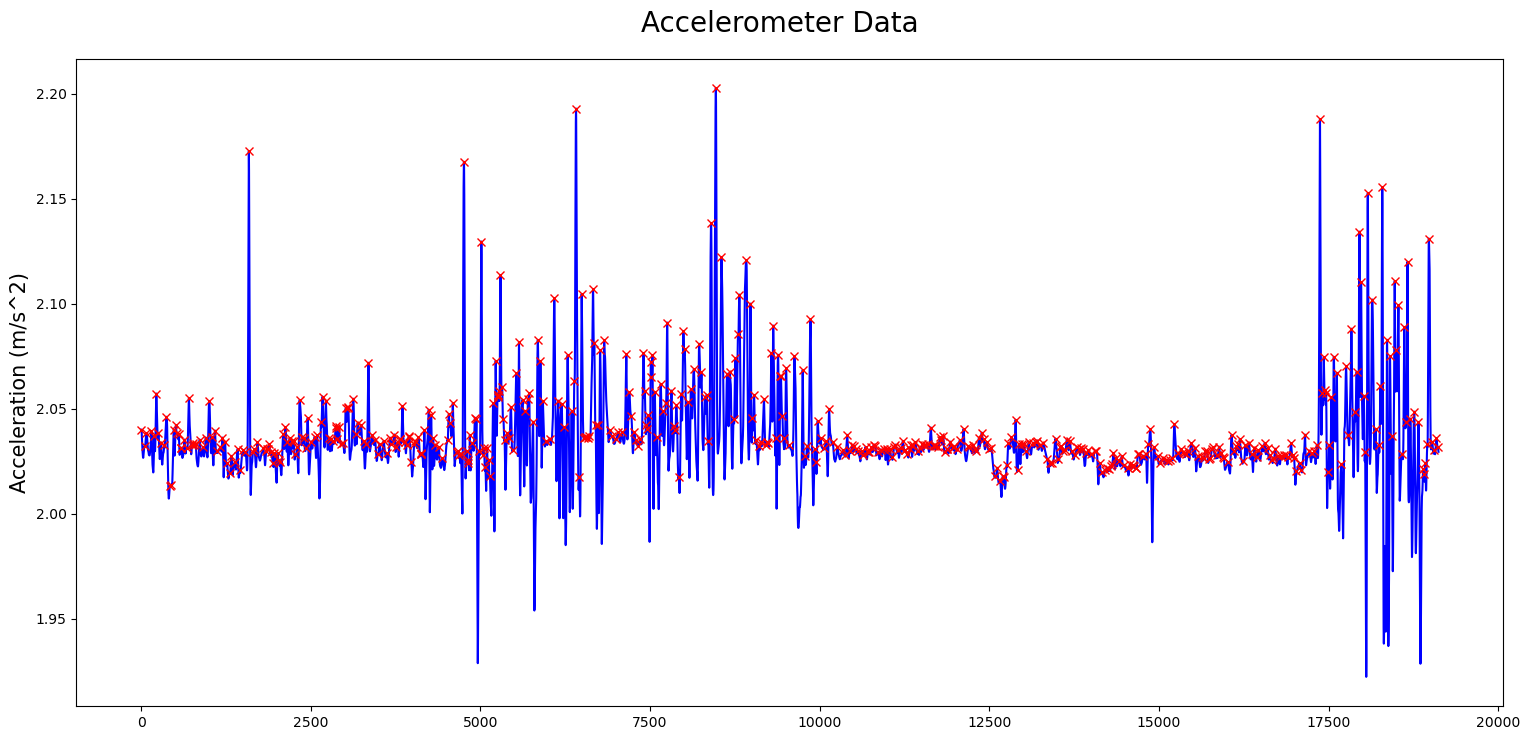

In [379]:
acc_peaks = peakutils.indexes(smoothed_acc_mag)

fig, ax = plt.subplots(1,1)
fig.set_figheight(7.5)
fig.set_figwidth(15)

fig.suptitle("Accelerometer Data", fontsize = 20)
fig.tight_layout()

ax.plot(smoothed_acc_mag, 'b')
ax.plot(acc_peaks, smoothed_acc_mag[acc_peaks], "rx")
ax.set_ylabel('Acceleration (m/s^2)', fontdict = {'size':15})

plt.show()

We can see from the above visualisation that we have correctly identified the peaks. We can now count the peaks to show the step count:

In [382]:
print('Step count is', str(len(acc_peaks)))

Step count is 534


# Summary and further steps

This is a very basic analysis of the sensor data and only utilises a small amount of the data provided. The conclusions are potentially quite naive without fully understanding the nature of the sensor, examining all of the variables, and looking at correlations. Given more time with the data there are a number of steps I would proceed with from this point:

* Improve all visualisations using Seaborn and Plotly.
* Examine variables such as temperature, posture and time, and how they correlate with and inform the sensor data.
* Examine heart rate variability.